In [ ]:
!pip install tensorflow
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold as skfold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB as bernoulli
from sklearn.linear_model import LogisticRegression as logistic_regr
from sklearn.ensemble import RandomForestClassifier as random_forest
from sklearn.svm import SVC as svc
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.naive_bayes import MultinomialNB as naiveB
from sklearn.ensemble import VotingClassifier as voting_
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import log_loss, make_scorer, precision_score, accuracy_score, f1_score, confusion_matrix, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


There are 0 missing feature values.

There are 0 duplicate rows.

There are 11 unique prognoses (Labels).

There are 64 unique symptoms (Features).

train_data dataset length: 707
test_data dataset length: 303




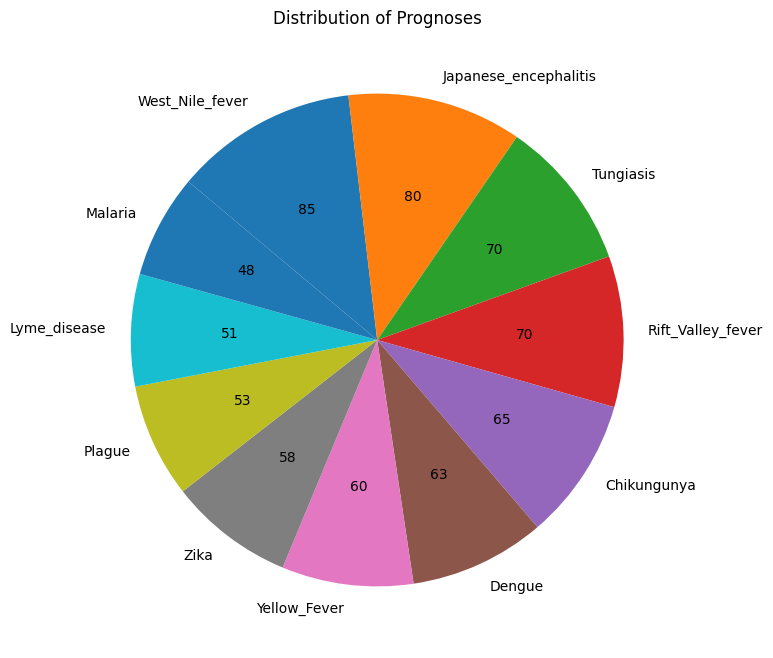

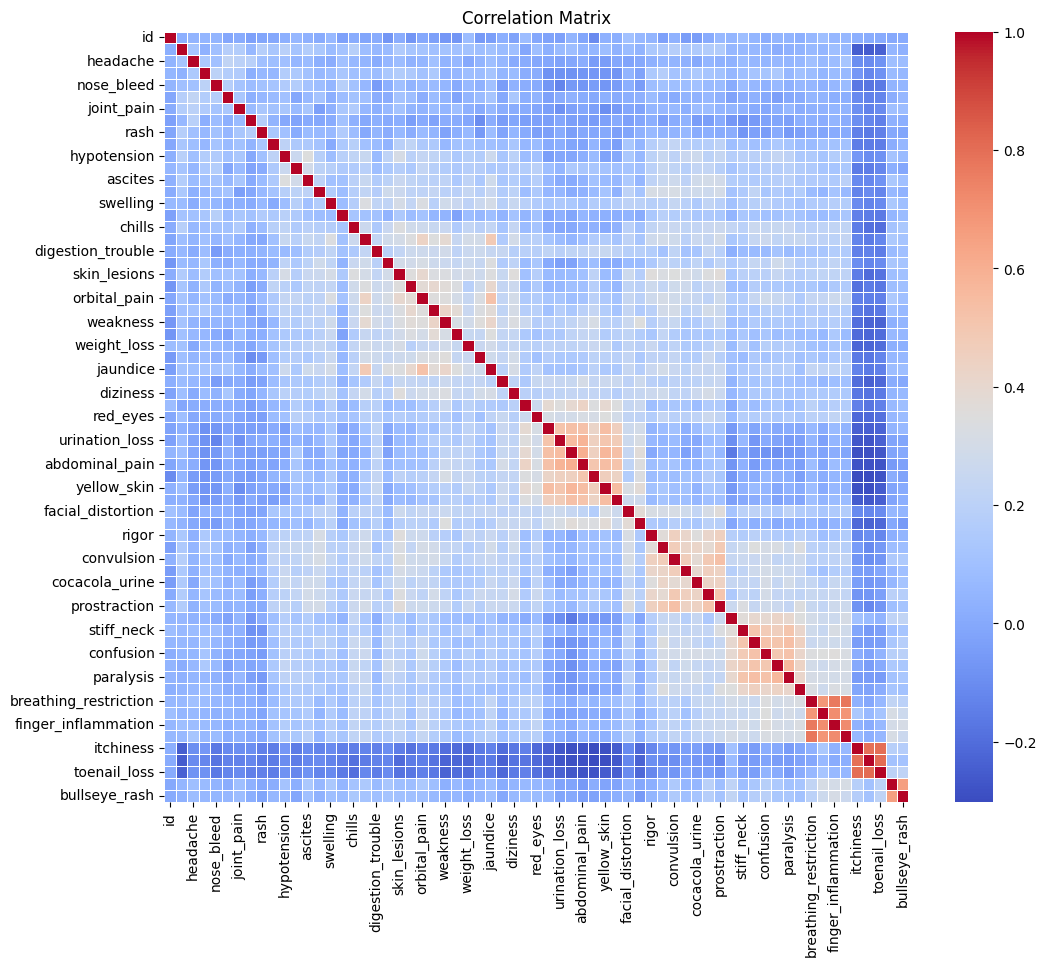

[[-1.81592700e+00  2.72377702e-01  8.27399406e-01  4.46051977e-01
   4.88800234e-01 -2.35998130e-01  2.34646268e-01 -5.57984219e-01
  -7.49489991e-01 -5.91626745e-02  5.24321435e-01 -4.28620029e-01
   6.09986101e-01  9.42758859e-01  1.86866864e-01  3.36302467e-01
   1.23023977e-02 -2.34159394e-01  2.13676229e-01 -5.27362415e-01
  -2.98738060e-01 -5.74224783e-01 -2.91010207e-01 -5.03889539e-01
  -2.98820935e-02  7.64486444e-02 -1.65181488e-01  3.71946346e-01
  -6.07789638e-01 -4.40314256e-01  2.09762059e-03 -2.34420374e-02
  -3.45144306e-01  2.05871918e-02  1.59476068e-01]
 [-9.64621478e-02  8.73658066e-01  4.49385434e-02 -8.43959287e-01
   4.33741831e-01 -1.20945077e-01 -2.18368896e-01  1.75817795e-02
   7.28906717e-01 -8.57774465e-02  5.58702102e-01 -5.32945077e-01
  -2.02789095e-01 -4.58937313e-01  2.02582172e-01 -6.08480475e-01
   5.85824607e-01 -6.32882823e-01  1.86803843e-01  6.67806301e-01
  -2.34327665e-01  6.26556679e-01  2.10012029e-01 -2.57915996e-01
  -1.44911900e+00  6.4389

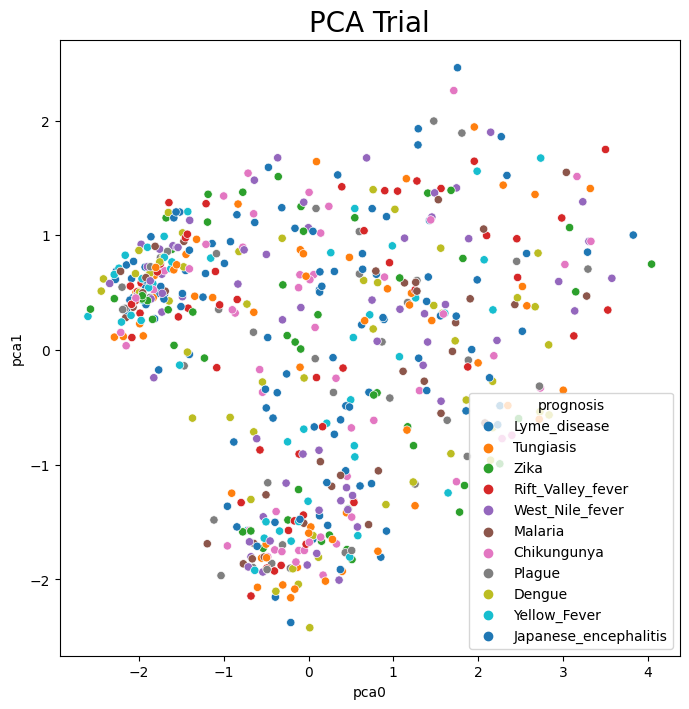

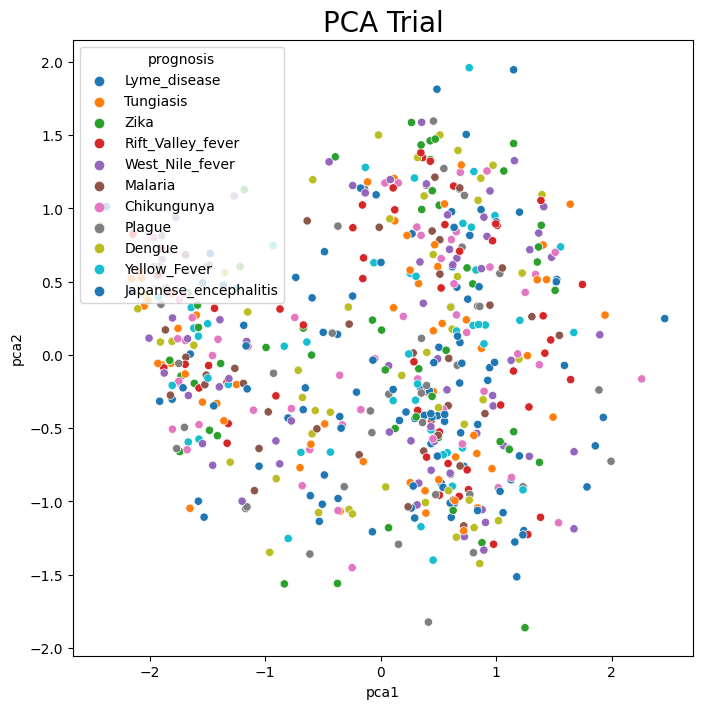

In [ ]:
train_data = pd.read_csv('/content/train.csv')
test_data= pd.read_csv('/content/test.csv')

# Check for missing values
missing_values = train_data.isna().sum().sum()
print(f'There are {missing_values} missing feature values.\n')

# Check for duplicate rows
duplicate_rows = len(train_data) - len(train_data.drop_duplicates())
print(f'There are {duplicate_rows} duplicate rows.\n')

# Print unique target values
unique_targets = train_data['prognosis'].nunique()
print(f'There are {unique_targets} unique prognoses (Labels).\n')

# Get list of unique features and print quantity
features = train_data.columns.difference(['id', 'prognosis'])
num_unique_features = len(features)
print(f'There are {num_unique_features} unique symptoms (Features).\n')

# Get length of train_data and test datasets
print(f'train_data dataset length: {len(train_data)}')
print(f'test_data dataset length: {len(test_data)}\n\n')

# Count the occurrences of each unique prognosis
prognosis_counts = train_data['prognosis'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(prognosis_counts, labels=prognosis_counts.index, startangle=140, counterclock=False,autopct=lambda p:f'{int(p*sum(prognosis_counts)/100)}')
plt.title('Distribution of Prognoses')
plt.show()

# Calculate the correlation matrix for numeric columns
numeric_columns = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_data['prognosis'])

# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_data[features],
                                                      encoded_labels,
                                                      train_size=0.80,
                                                      shuffle=True,
                                                      random_state=2,
                                                      stratify=train_data[['prognosis']])
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
# Create a PCA instance with 15 components and fit_transform
k=35
pca= PCA(n_components=k)
X_transformed_pca = pca.fit_transform(X_train)

# Display a sample of the transformed data with explained variance of the principal components
print(X_transformed_pca[:5])  # Display the first 5 rows of transformed data
explained_variance_ratio= pca.explained_variance_ratio_
for i in range(len(explained_variance_ratio)):
    print(f'PC_{i} variance explained ratio: {np.round(explained_variance_ratio[i], decimals=3)}')

# Plotting the transformed data along the principal component axes
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=pd.concat([pd.DataFrame(X_transformed_pca, columns=[f'pca{i}' for i in range(k)]),
                                train_data[['prognosis']]], axis=1), x='pca0', y='pca1', hue='prognosis', palette='tab10').set_title('PCA Trial', fontsize=20)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=pd.concat([pd.DataFrame(X_transformed_pca, columns=[f'pca{i}' for i in range(k)]),
                                train_data[['prognosis']]], axis=1), x='pca1', y='pca2', hue='prognosis', palette='tab10').set_title('PCA Trial', fontsize=20)
plt.show()

# Rank the features based on their contributions to PCA components
feature_ranking = np.argsort(explained_variance_ratio)[::-1]

# Select the top 35 features based on explained variance ratio
top_35_features = X_train.columns[feature_ranking[:k]]
# Select the top 35 features based on feature_ranking
top_35_features = X_train.columns[feature_ranking[:k]]

# Create X_train_pca with only the top 35 features
X_train_pca = X_train[top_35_features]

# Create X_valid_pca with only the top 35 features
X_valid_pca = X_valid[top_35_features]

# Create test_data with only the top 35 features
test_data=test_data[top_35_features]

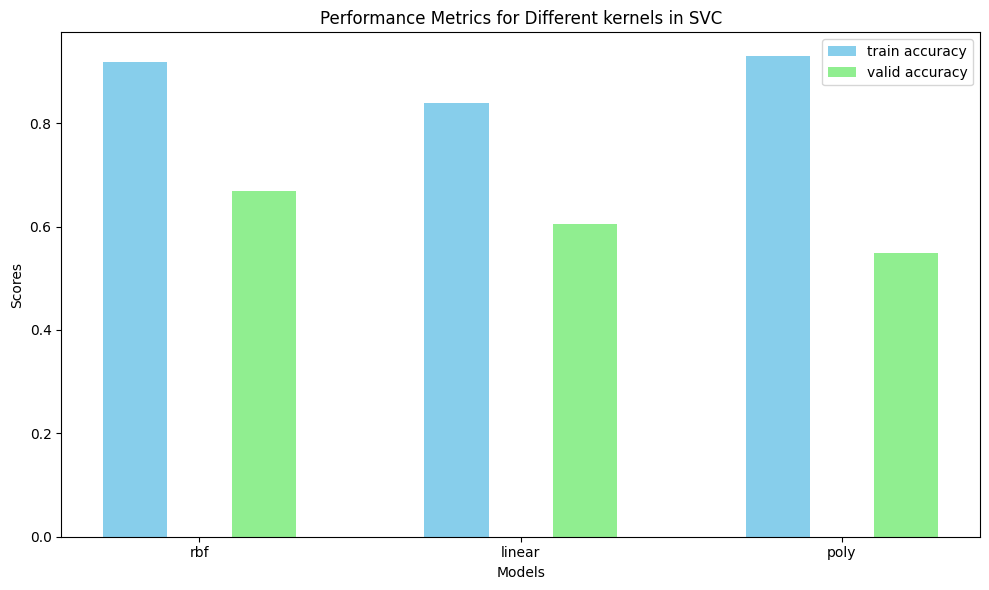

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

C_values = [100, 200, 300, 400, 500]  # Different regularization strengths

kernels = ['rbf', 'linear', 'poly']
train_accuracies = []
valid_accuracies = []

for ker in kernels:
    model = svc(kernel = ker, probability = True)
    model.fit(X_train_pca, y_train)

    y_pred_train = model.predict_proba(X_train_pca)
    y_pred_valid = model.predict_proba(X_valid_pca)

    training_accuracy = top_k_accuracy_score(y_train, y_pred_train,k=3)
    validation_accuracy = top_k_accuracy_score(y_valid, y_pred_valid,k=3)

    train_accuracies.append(training_accuracy)
    valid_accuracies.append(validation_accuracy)

plt.figure(figsize=(10, 6))
bar_width = 0.2
x = np.arange(3)
plt.bar(x - bar_width, train_accuracies, bar_width, label='train accuracy', color='skyblue')
plt.bar(x + bar_width, valid_accuracies, bar_width, label='valid accuracy', color='lightgreen')

plt.ylabel('Scores')
plt.title('Performance Metrics for Different kernels in SVC')
plt.legend()

plt.xlabel('Models')
plt.xticks(x, ['rbf','linear','poly'])

plt.tight_layout()
plt.show()


In [ ]:
#function for perform grid search
def grid_search(model,params):
  search = GridSearchCV(model,params, cv=3)
  search.fit(X_train_pca,y_train)
  best_features = {}
  for i in params:
    best_features[i] = search.best_params_[i]
  print("best features for "+str(model) + ": " + str(best_features))
  return best_features

In [ ]:
  model_name = ['logis','rf','svc','xgb','mlp','naive']

  models = [logistic_regr(multi_class = 'multinomial',class_weight='balanced'),
            random_forest(bootstrap = True),
            svc(probability = True),xgb.XGBClassifier(), mlp(max_iter = 20),naiveB()]

In [ ]:
#grid search

best_params = {}


best_params['logis'] = grid_search(logistic_regr(), {'C': [1, 10, 100],
                                                     'penalty': ['l1', 'l2'],
                                                     'max_iter': [100, 200]})

best_params['rf'] = grid_search(random_forest(), {'n_estimators': [100,200,300],
                                                  'max_depth': [10,20,30,None], 'min_samples_split': [2,5,10,15]})

best_params['svc'] = grid_search(svc(), { 'C': [0.1, 0.5, 1],
                                         'kernel': ['rbf', 'poly'],'degree': [2, 3, 4],'gamma': ['scale', 'auto'] })

best_params['xgb'] = grid_search(xgb.XGBClassifier(), {'max_depth': [3, 5, 7],
                                                       'learning_rate': [0.01, 0.1],'n_estimators': [50, 100],'subsample': [0.6, 0.8, 1.0]})

best_params['mlp'] = grid_search(mlp(),{'hidden_layer_sizes': [(40,40),(80,80)],
                                                  'learning_rate_init': [0.001,0.01], 'batch_size': [32,64]})

best_params['naive'] = grid_search(naiveB(),{'alpha': [0.1, 0.8]})



best features for LogisticRegression(): {'C': 1, 'penalty': 'l2', 'max_iter': 100}
best features for RandomForestClassifier(): {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10}
best features for SVC(): {'C': 1, 'kernel': 'rbf', 'degree': 2, 'gamma': 'scale'}
best features for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
             

In [ ]:
def classwise_analysis(y_test, y_pred):
    y_pred = np.array(y_pred)

    classes = np.unique(y_test)
    for name in classes:
        index = np.where(y_test == name)
        test_accuracy = accuracy_score(y_test[index], y_pred[index])

        print(f"Class {name} - Accuracy: {test_accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def cross_validation(model, x, y, x_test, y_test):
    model.fit(x, y)

    y_probab_train = model.predict_proba(x)
    y_pred_train = []
    for i in range(0, len(y_probab_train)):
        sorted_prediction = np.argsort(y_probab_train[i])[::-1]
        top3_train = sorted_prediction[:3]
        if y[i] in top3_train:
            y_pred_train.append(y[i])
        else:
            y_pred_train.append(top3_train[0])

    train_accuracy = accuracy_score(y, y_pred_train)
    print(f"Top-3 Training Accuracy: {train_accuracy:.4f}")

    train_logloss = log_loss(y, y_probab_train)
    print(f"Training Log Loss: {train_logloss:.4f}")

    y_pred_probab = model.predict_proba(x_test)
    y_pred = []
    for i in range(0, len(y_pred_probab)):
        sorted_prediction = np.argsort(y_pred_probab[i])[::-1]
        top3 = sorted_prediction[:3]
        if y_test[i] in top3:
            y_pred.append(y_test[i])
        else:
            y_pred.append(top3[0])

    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Top-3 Test Accuracy: {test_accuracy:.4f}")

    test_logloss = log_loss(y_test, y_pred_probab)
    print(f"Test Log Loss: {test_logloss:.4f}")

    confusionMatrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    classwise_analysis(y_test, y_pred)

    return train_accuracy, train_logloss, test_accuracy, test_logloss



Results for logistic model:
Top-3 Training Accuracy: 0.7717
Training Log Loss: 1.5700
Top-3 Test Accuracy: 0.5704
Test Log Loss: 2.1033


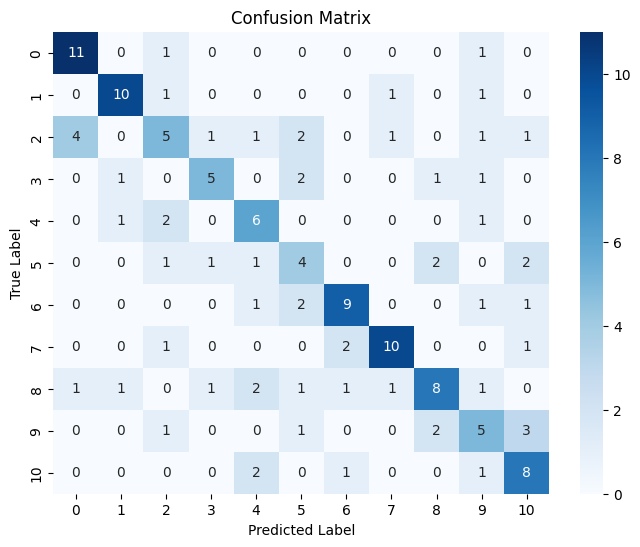

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.7692
Class 2 - Accuracy: 0.3125
Class 3 - Accuracy: 0.5000
Class 4 - Accuracy: 0.6000
Class 5 - Accuracy: 0.3636
Class 6 - Accuracy: 0.6429
Class 7 - Accuracy: 0.7143
Class 8 - Accuracy: 0.4706
Class 9 - Accuracy: 0.4167
Class 10 - Accuracy: 0.6667


Results for rf model:
Top-3 Training Accuracy: 0.9965
Training Log Loss: 1.2481
Top-3 Test Accuracy: 0.6056
Test Log Loss: 1.9321


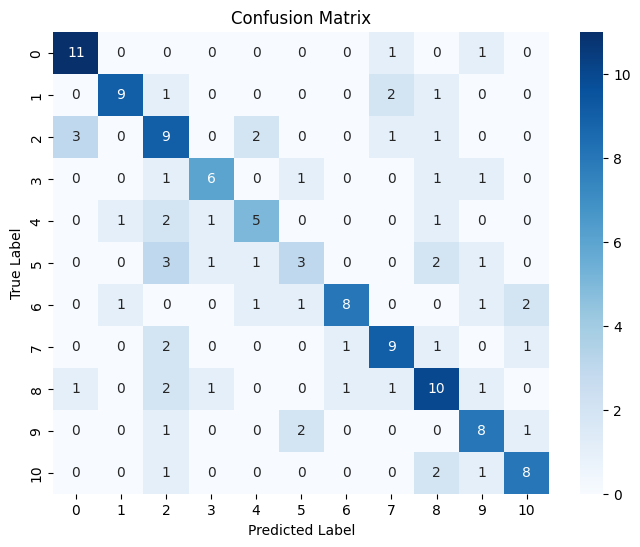

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.6923
Class 2 - Accuracy: 0.5625
Class 3 - Accuracy: 0.6000
Class 4 - Accuracy: 0.5000
Class 5 - Accuracy: 0.2727
Class 6 - Accuracy: 0.5714
Class 7 - Accuracy: 0.6429
Class 8 - Accuracy: 0.5882
Class 9 - Accuracy: 0.6667
Class 10 - Accuracy: 0.6667


Results for svc model:
Top-3 Training Accuracy: 0.9204
Training Log Loss: 1.3701
Top-3 Test Accuracy: 0.6479
Test Log Loss: 1.8792


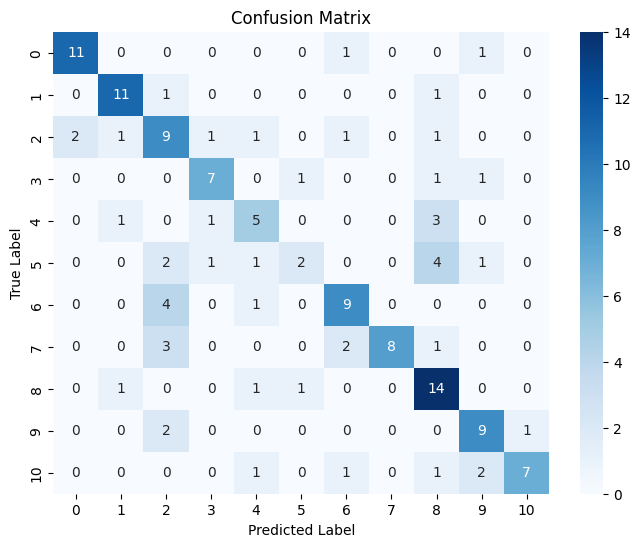

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.8462
Class 2 - Accuracy: 0.5625
Class 3 - Accuracy: 0.7000
Class 4 - Accuracy: 0.5000
Class 5 - Accuracy: 0.1818
Class 6 - Accuracy: 0.6429
Class 7 - Accuracy: 0.5714
Class 8 - Accuracy: 0.8235
Class 9 - Accuracy: 0.7500
Class 10 - Accuracy: 0.5833


Results for xgb  model:
Top-3 Training Accuracy: 0.9168
Training Log Loss: 1.2915
Top-3 Test Accuracy: 0.6056
Test Log Loss: 1.9724


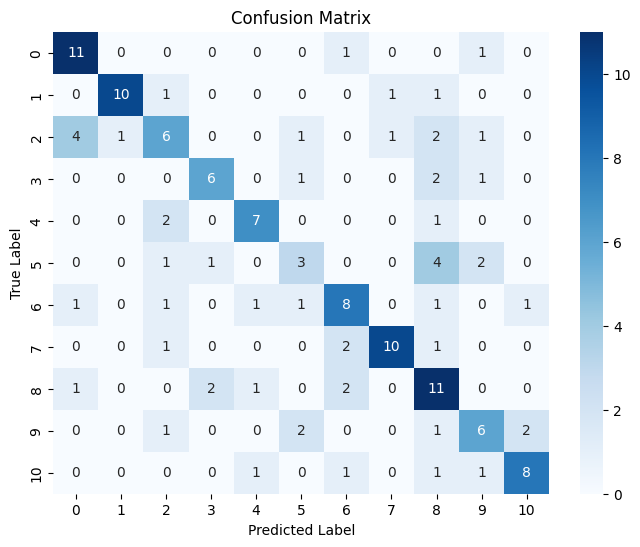

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.7692
Class 2 - Accuracy: 0.3750
Class 3 - Accuracy: 0.6000
Class 4 - Accuracy: 0.7000
Class 5 - Accuracy: 0.2727
Class 6 - Accuracy: 0.5714
Class 7 - Accuracy: 0.7143
Class 8 - Accuracy: 0.6471
Class 9 - Accuracy: 0.5000
Class 10 - Accuracy: 0.6667


Results for mlp model:
Top-3 Training Accuracy: 0.9681
Training Log Loss: 0.6982
Top-3 Test Accuracy: 0.5352
Test Log Loss: 2.6504


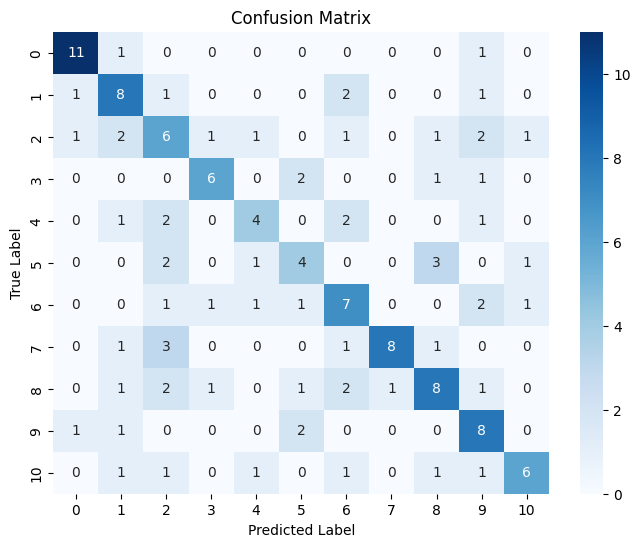

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.6154
Class 2 - Accuracy: 0.3750
Class 3 - Accuracy: 0.6000
Class 4 - Accuracy: 0.4000
Class 5 - Accuracy: 0.3636
Class 6 - Accuracy: 0.5000
Class 7 - Accuracy: 0.5714
Class 8 - Accuracy: 0.4706
Class 9 - Accuracy: 0.6667
Class 10 - Accuracy: 0.5000


Results for naive bayes model:
Top-3 Training Accuracy: 0.6655
Training Log Loss: 1.8690
Top-3 Test Accuracy: 0.5775
Test Log Loss: 2.0710


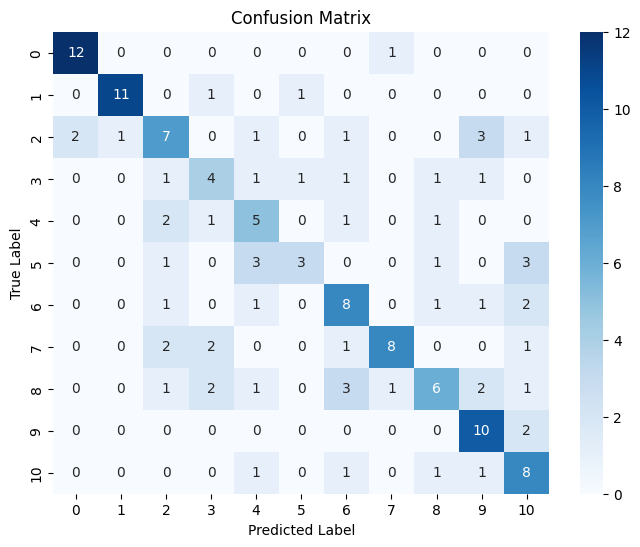

Class 0 - Accuracy: 0.9231
Class 1 - Accuracy: 0.8462
Class 2 - Accuracy: 0.4375
Class 3 - Accuracy: 0.4000
Class 4 - Accuracy: 0.5000
Class 5 - Accuracy: 0.2727
Class 6 - Accuracy: 0.5714
Class 7 - Accuracy: 0.5714
Class 8 - Accuracy: 0.3529
Class 9 - Accuracy: 0.8333
Class 10 - Accuracy: 0.6667


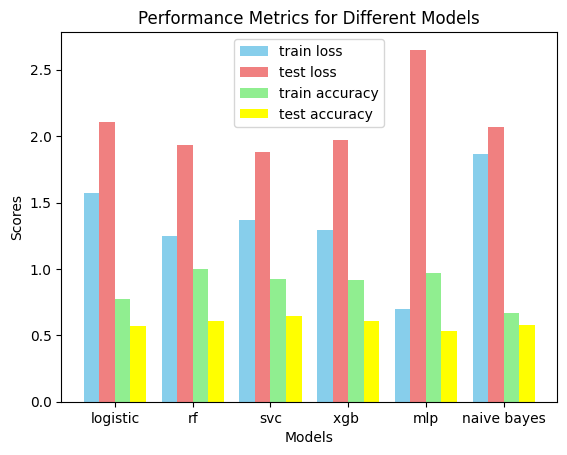

In [ ]:
m1, m2, m3, m4 = [], [], [], []

model_name = ['logistic', 'rf', 'svc', 'xgb ', 'mlp', 'naive bayes','VC']

models_new =  [
    logistic_regr(multi_class='multinomial', class_weight='balanced', **best_params['logis']),
    random_forest(**best_params['rf'], bootstrap=True),
    svc(**best_params['svc'], probability=True),
    xgb.XGBClassifier(objective='multi:softprob', **best_params['xgb']),
    mlp(**best_params['mlp'], max_iter=10),
    naiveB(**best_params['naive'])
]

for model, name in zip(models_new, model_name):
    print(f"\n\nResults for {name} model:")
    top_acc_training,train_loss, top_acc_rest, rest_loss = cross_validation(model, X_train_pca, y_train, X_valid_pca, y_valid)
    m1.append(train_loss)
    m2.append(rest_loss)
    m3.append(top_acc_training)
    m4.append(top_acc_rest)

x = np.arange(6)
bar_width = 0.2
plt.bar(x - 1.5 * bar_width, m1, bar_width, label='train loss', color='skyblue')
plt.bar(x - 0.5 * bar_width, m2, bar_width, label='test loss', color='lightcoral')
plt.bar(x + 0.5 * bar_width, m3, bar_width, label='train accuracy', color='lightgreen')
plt.bar(x + 1.5 * bar_width, m4, bar_width, label='test accuracy', color='yellow')

plt.xlabel('Models')
plt.xticks(x, model_name[:6])

plt.ylabel('Scores')
plt.title('Performance Metrics for Different Models')
plt.legend()

plt.show()

In [ ]:
all_models = [
              ('logreg',logistic_regr( multi_class = 'multinomial',class_weight='balanced', **best_params['logis'])),
            ('rf',random_forest(**best_params['rf'], bootstrap = True)),
            ('svc',svc(**best_params['svc'], probability = True)),
              ('xgb', xgb.XGBClassifier(objective='multi:softprob', **best_params['xgb'])),
              ('mlp',mlp( **best_params['mlp'],max_iter = 10)),
              ('naive',naiveB(**best_params['naive']))
]

rankings = np.argsort(m4)
print(rankings)

best_models = [all_models[x] for x in rankings[-3:]]

[0 4 5 3 1 2]


Top-3 Training Accuracy: 0.9611
Training Log Loss: 1.2925
Top-3 Test Accuracy: 0.6620
Test Log Loss: 1.9056


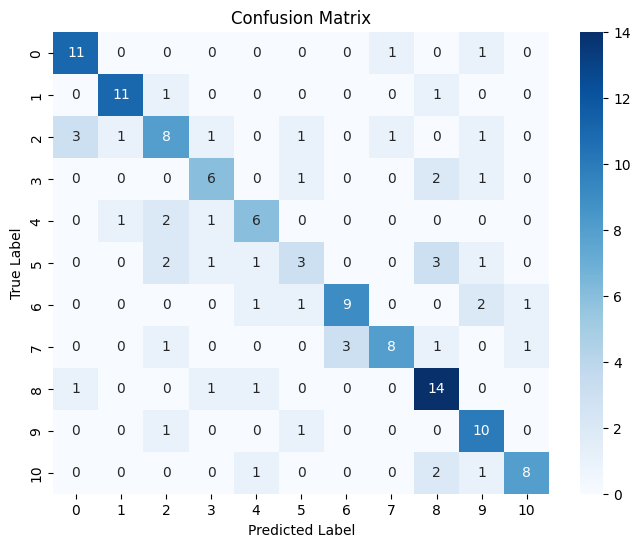

Class 0 - Accuracy: 0.8462
Class 1 - Accuracy: 0.8462
Class 2 - Accuracy: 0.5000
Class 3 - Accuracy: 0.6000
Class 4 - Accuracy: 0.6000
Class 5 - Accuracy: 0.2727
Class 6 - Accuracy: 0.6429
Class 7 - Accuracy: 0.5714
Class 8 - Accuracy: 0.8235
Class 9 - Accuracy: 0.8333
Class 10 - Accuracy: 0.6667


In [ ]:
voting_classifier = voting_(estimators = best_models, voting = 'soft')
top_acc_training, train_loss, top_acc_rest, rest_loss  = cross_validation(voting_classifier, X_train_pca, y_train, X_valid_pca, y_valid)


In [ ]:
m1.append(train_loss)
m2.append(rest_loss)
m3.append(top_acc_training)
m4.append(top_acc_rest)

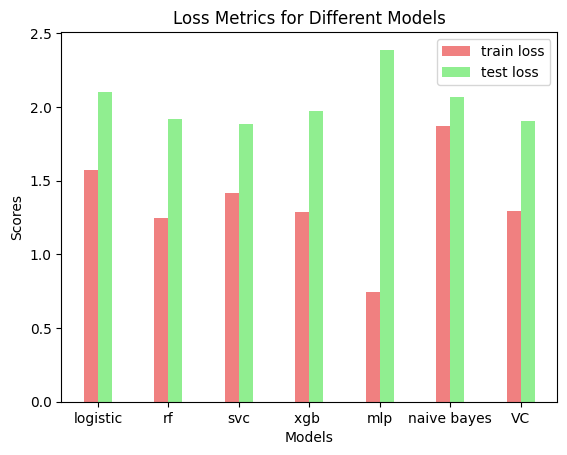

In [ ]:
x = np.arange(0,7)
bar_width = 0.2
plt.bar(x - 0.5 * bar_width, m1, bar_width, label='train loss', color='lightcoral')
plt.bar(x + 0.5 * bar_width, m2, bar_width, label='test loss', color='lightgreen')

plt.xlabel('Models')
plt.xticks(x,model_name)

plt.ylabel('Scores')
plt.title('Loss Metrics for Different Models')
plt.legend()

plt.show()

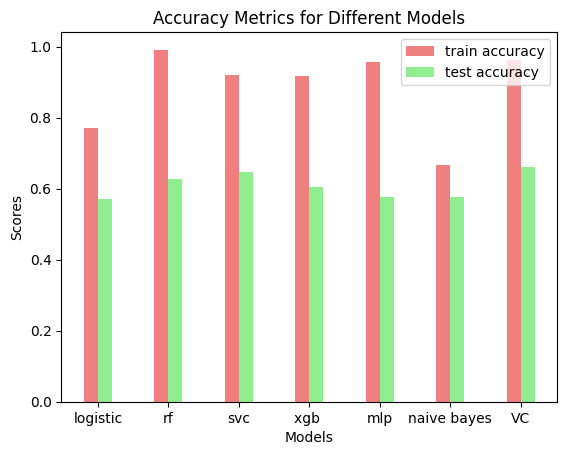

In [ ]:
x = np.arange(7)
bar_width = 0.2
plt.bar(x - 0.5 * bar_width, m3, bar_width, label='train accuracy', color='lightcoral')
plt.bar(x + 0.5 * bar_width, m4, bar_width, label='test accuracy', color='lightgreen')

plt.xlabel('Models')
plt.xticks(x,model_name)

plt.ylabel('Scores')
plt.title('Accuracy Metrics for Different Models')
plt.legend()

plt.show()